In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split

from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.linear_model import LassoCV
from sklearn.datasets import make_regression


## Pre-Processing 
- Read the feather file into a dataframe 
- Drop some columns that do we do not want as the independent variables (Xs)

In [8]:
# df = pd.read_csv('lending_club_clean_sample.csv')
# df = pd.read_feather('lending_club_smaller_sample.feather')

# Read the feather file 
df = pd.read_feather('lending_club_clean.feather')

See which values we can classify as a default or cannot repay the loan 

In [9]:
# Check what kind of status does our Y variable have 
print(df[['loan_status']].value_counts())

loan_status                                        
Fully Paid                                             1497783
Current                                                1031016
Charged Off                                             362548
Late (31-120 days)                                       16154
In Grace Period                                          10028
Late (16-30 days)                                         2719
Issued                                                    2062
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                    433
dtype: int64


In [10]:
# Convert description into a default or not default prediction 
default_description = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", "In Grace Period",
            "Late (16-30 days)", "Late (31-120 days)"]
df['default'] = df['loan_status'].apply(lambda status: 1 if status in default_description else 0).astype(int) 

In [11]:
# Create a different dataframe for the Y variable 
y = df['default']

# Drop unnecessary variables 
df = df.drop(['id', 'default', 'revol_util' ,'sec_app_earliest_cr_line','loan_status', 'grade', 'sub_grade', 
              'emp_title', 'issue_d','url','title',
              'zip_code','earliest_cr_line','last_pymnt_d',
              'next_pymnt_d','last_credit_pull_d','hardship_type',
              'hardship_start_date','hardship_end_date',
              'payment_plan_start_date','hardship_loan_status','debt_settlement_flag'], axis=1)


In [12]:
# Properly turn variables that are categorical into the correct data type
df = pd.concat([df,pd.get_dummies(df["emp_length"],drop_first=True)],axis=1)
df = pd.concat([df,pd.get_dummies(df["addr_state"],drop_first=True)],axis=1)
df = pd.concat([df,pd.get_dummies(df["home_ownership"],drop_first=True)],axis=1)
df = pd.concat([df,pd.get_dummies(df["verification_status"],drop_first=True)],axis=1)
df = pd.concat([df,pd.get_dummies(df["pymnt_plan"],drop_first=True)],axis=1)
df = pd.concat([df,pd.get_dummies(df["purpose"],drop_first=True)],axis=1)
df = pd.concat([df,pd.get_dummies(df["initial_list_status"],drop_first=True)],axis=1)
df = pd.concat([df,pd.get_dummies(df["application_type"],drop_first=True)],axis=1)
df = pd.concat([df,pd.get_dummies(df["hardship_flag"],drop_first=True)],axis=1)
df = pd.concat([df,pd.get_dummies(df["hardship_reason"],drop_first=True)],axis=1)
df = pd.concat([df,pd.get_dummies(df["verification_status_joint"],drop_first=True)],axis=1)
df = pd.concat([df,pd.get_dummies(df["hardship_status"],drop_first=True)],axis=1)

# drop the categorical columns as well 
df = df.drop(['emp_length', 'addr_state', 'home_ownership', 
              'verification_status', 'pymnt_plan','purpose','initial_list_status',
              'application_type','hardship_flag',
              'hardship_reason','verification_status_joint','hardship_status'], axis=1)

 

# Split the Test - Train Dataset 

In [13]:
# Split train test dataset 
X_train, X_OOS_test, y_train, y_OOS_test = train_test_split(df, y, test_size=0.20, random_state=66)

## Employ LASSO to reduce initial dimension 
We want to use LASSO right now to reduce the dimension from almost 100 to only those that play a significant role in predicting our dependent variable. 

In [14]:
# We do the LASSO to determine which variables are important and which are not 
lasso = linear_model.Lasso(alpha=1)
lasso.fit(X_train, y_train)

C:\Users\16920\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.246e+03, tolerance: 2.718e+01
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=1)

In [18]:
# Print Lasso Coefficients that is not 0 
coefficients = dict(zip(X_train.columns, lasso.coef_))
print("Lasso Coefficients:")
lasso_picked_var = []
for feature, coef in coefficients.items():
    if coef != 0:
        lasso_picked_var.append(feature)
        print(f"{feature}: {coef}")

Lasso Coefficients:
loan_amnt: 3.215231192659518e-05
funded_amnt: 1.1160011603047951e-05
annual_inc: -1.8982938476397474e-08
revol_bal: -1.3455352569173814e-07
out_prncp: -4.585172374295004e-05
total_pymnt: -1.8772799799737878e-05
total_rec_prncp: -2.7344365070971457e-05
total_rec_int: 2.031478072522598e-05
recoveries: 2.9901604379513027e-05
last_pymnt_amnt: -2.22202593993967e-06
last_fico_range_high: -0.000714724741138563
last_fico_range_low: -0.00035849692967635974
annual_inc_joint: 2.8253078616216065e-08
tot_coll_amt: -1.1181006617159456e-08
tot_cur_bal: -4.49836025494085e-08
total_bal_il: -1.6930576857907e-07
max_bal_bc: -2.493930417498113e-07
total_rev_hi_lim: 7.770688821401887e-08
avg_cur_bal: 3.416832458240612e-08
bc_open_to_buy: 4.205030071359258e-07
tot_hi_cred_lim: 3.203413496903826e-08
total_bal_ex_mort: 6.628786150700645e-08
total_bc_limit: -3.765805148543368e-08
total_il_high_credit_limit: 1.9848973632376987e-12
hardship_amount: 4.7275769945532336e-05
hardship_payoff_balan

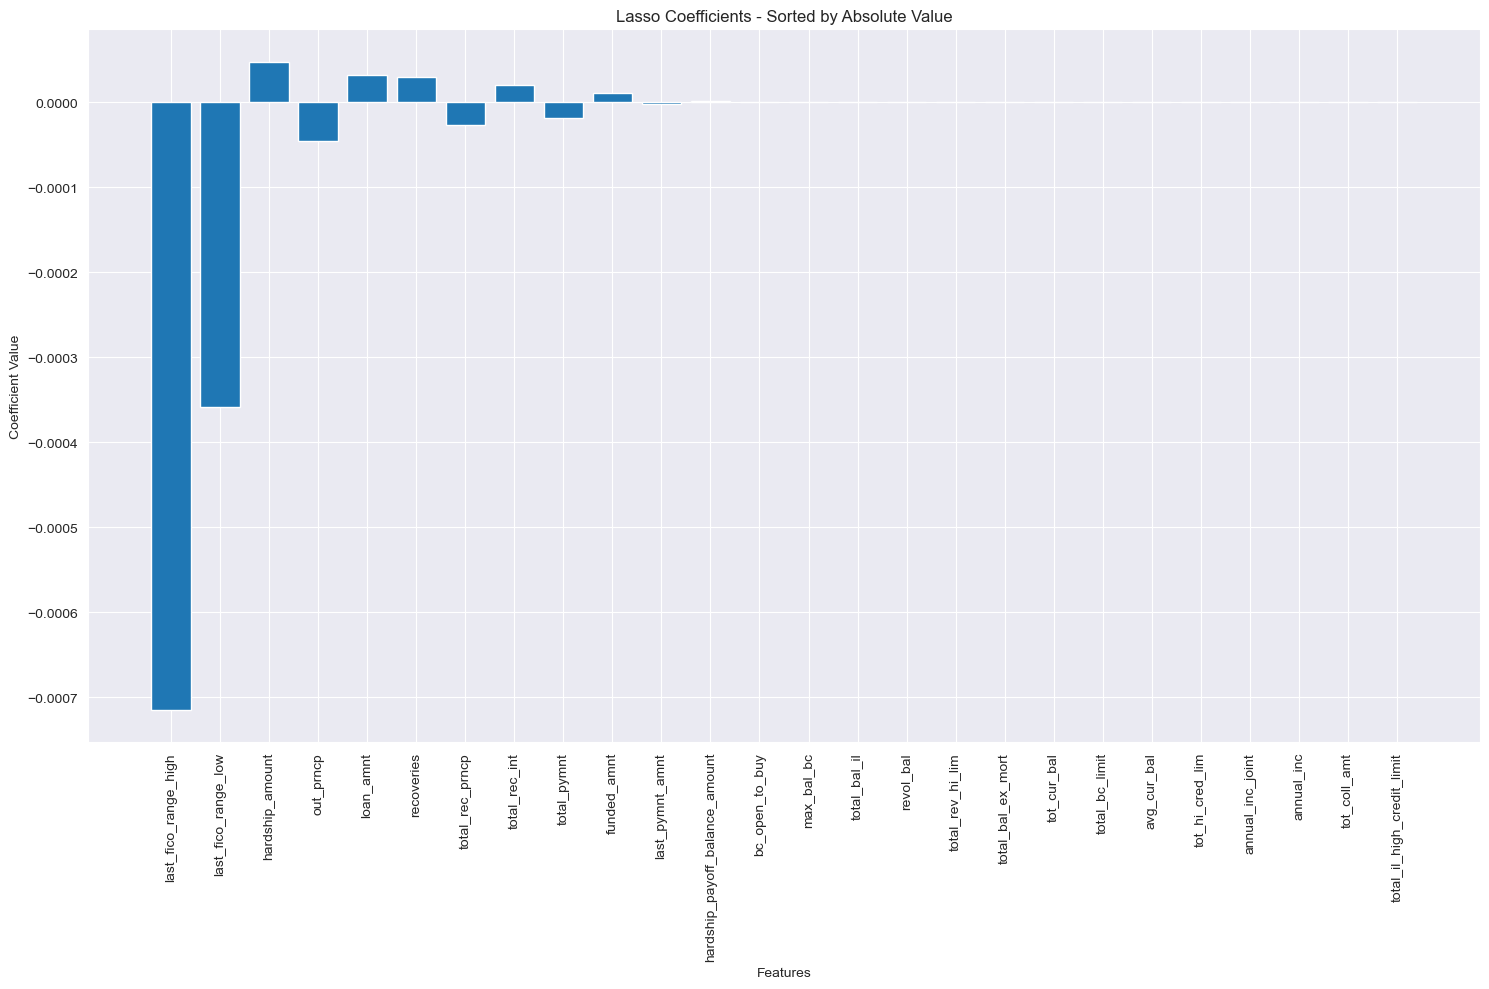

In [23]:
# Variable Visualization

# Sorting the DataFrame by the absolute value of the coefficients
sorted_coefficients_df = coefficients_df[coefficients_df['Coefficient'] != 0].sort_values('abs_coef', ascending=False)

# Drop the 'abs_coef' column as it's no longer needed for plotting
sorted_coefficients_df.drop('abs_coef', axis=1, inplace=True)

# Plotting all non-zero features, sorted by the absolute value of their coefficients
plt.figure(figsize=(15, 10))
plt.bar(sorted_coefficients_df['Feature'], sorted_coefficients_df['Coefficient'])
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Lasso Coefficients - Sorted by Absolute Value')

# Rotate the feature names on x-axis to avoid overlap
plt.xticks(rotation=90)

# Use tight layout to ensure the labels fit into the figure area
plt.tight_layout()

# Show the plot
plt.show()


## Uncomment the codes below incase the python needs to restart to save time doing the LASSO again 

In [2]:
# pick the X variables that LASSO tells us are significant
# X_train = X_train[lasso_picked_var]
# X_OOS_test = X_OOS_test[lasso_picked_var]

# Output these files onto a csv file just incase we need to load them in again :) 
# X_train.to_csv('X_train.csv', index=False) 
# X_OOS_test.to_csv('X_OOS_test.csv', index=False) 
# y_train.to_csv('y_train.csv', index=False) 
# y_OOS_test.to_csv('y_OOS_test.csv', index=False) 

# X_train = pd.read_csv('X_train.csv')
# y_train = pd.read_csv('y_train.csv')['default']
# X_OOS_test = pd.read_csv('X_OOS_test.csv')
# y_OOS_test = pd.read_csv('y_OOS_test.csv')['default']



## Undersampling 
Since we see that the data is highly imbalanced, we try to oversample the data set with random under sampler. 

In [7]:
# from imblearn.over_sampling import SMOTE

# solve error by downgrading to install scikit-learn==1.2.2 
# ''' steps : 
# 1. install pip 
# 2. uninstall sci-kit 
# 3. uninstall imblearn
# 4. install sci-kit 1.2.2 
# 5. install imblearn 
# '''

# sm = SMOTE(random_state=42, sampling_strategy=0.2)

In [8]:
# Undersampling 
from imblearn.under_sampling import RandomUnderSampler
# Undersample the dataset 
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

See if the data is now balance or not 

In [8]:
# Count the different values 
print(y_resampled.value_counts())

# -- Code to Inspect the data set -- 
# df_oversampled = X_resampled
# df_oversampled['Outcome_Variable'] = y_resampled
# df_oversampled
# fig, ax = plt.subplots(figsize=(10, 8))
# df_oversampled['Outcome_Variable'].value_counts().plot(kind='bar', ax=ax, fontsize=14)
# ax.set_title('Oversampled Dataset', fontsize=16)
# ax.set_ylabel('Observation counts', fontsize=14)
# ax.set_xlabel('Class', fontsize=14)
# plt.show()


default
0          313925
1          313925
dtype: int64


## K-Fold Cross Validation 
We setup K-Fold cross validation for parameters fine-tuning in the models below as a 5 Fold. 

In [4]:
# Set up K-Fold Cross Validation 
n_splits = 5
shuffle = True
random_state = 809
cv = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
# plot = plot_cv_indices(cv, X_resampled, y_resampled, n_splits)

## Model 1 : Logistic Regression 

In [9]:
# Function to plot the K-Fold stuff, don't need to run it. 
def plot_cv_indices(cv, X, y, n_splits, lw=10):
    '''
    This function plots the Cross validation indices.
    '''
    
    fig, ax = plt.subplots(figsize = (15,8))
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=plt.cm.coolwarm,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes
    ax.scatter(range(len(X)), [ii + 1.5] * len(X), c=y, marker='_', lw=lw, cmap=plt.cm.Paired)

    # Formatting
    yticklabels = list(range(n_splits)) + ['Class']
    ax.set(yticks=np.arange(n_splits+1) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

In [139]:
# Model 1 : Logistic Model - K-Flod Cross Validation 
logistic_model = LogisticRegression(solver='lbfgs', max_iter=300)
for train_index, test_index in cv.split(X_resampled):
    X_cv_train, X_cv_test, y_cv_train, y_cv_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index], y_resampled.iloc[train_index], y_resampled.iloc[test_index]
    logistic_model.fit(X_cv_train, y_cv_train)
    #Cross-Validation Prediction Error
    score = logistic_model.score(X_cv_test, y_cv_test)
    print(score)

/Users/dhammatornriewcharoon/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9592338934458867


/Users/dhammatornriewcharoon/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9577685752966473


/Users/dhammatornriewcharoon/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9592338934458867


/Users/dhammatornriewcharoon/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9592100023891057
0.9564147487457195


/Users/dhammatornriewcharoon/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [121]:
# Just the logit regression, and OOS Prediction 
logit = LogisticRegression(solver='lbfgs', max_iter=1000)
logit.fit(X_resampled, y_resampled)    
score_OOS = logit.score(X_OOS_test, y_OOS_test)
print ("Logistic Model score :" , score_OOS)
y_pred = logit.predict(X_OOS_test)
print("Logistic Model Recall : " , recall_score(y_OOS_test, y_pred))
print("Logistic Model Precision : ", precision_score(y_OOS_test,y_pred))
print("Probability if you only predict 0s ", 1-round(95/56867,3))

Logistic Model score : 0.9846037709350093
Logistic Model Recall :  0.8631578947368421
Logistic Model Precision :  0.08668076109936575
Probability if you only predict 0s  0.998




## Model 2 : Lasso 

In [10]:
# Model 2 : LASSO 
# Cross Validate the penalty term in lasso
cross_validate_result = {}
cross_validate_recall = {} 
cross_validate_precision = {} 

# Set Hyperparameter (Lambda) values to cross validate here !!!!! 
lambdas = [0.01, 0.1]
for lambda_value in lambdas:
    print('Training Lasso Lambda Value : ', lambda_value)
    accuracies = []
    recall_scores = [] 
    precision_scores = [] 
    lasso = linear_model.Lasso(alpha=lambda_value)
    for train_index, test_index in cv.split(X_resampled):
        # change to loc to define the rows in the dataframe 
        X_cv_train, X_cv_test, y_cv_train, y_cv_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index], y_resampled.iloc[train_index], y_resampled.iloc[test_index]
        lasso.fit(X_cv_train, y_cv_train)
        y_pred = lasso.predict(X_cv_test)
        y_pred_classification = [1 if x >= 0.5 else 0 for x in y_pred]

        #Cross-Validation Prediction Error
        score = lasso.score(X_cv_test, y_cv_test)
        accuracies.append(score)
        recall_scores.append(recall_score(y_cv_test, y_pred_classification))
        precision_scores.append(precision_score(y_cv_test,y_pred_classification))

    cross_validate_result[lambda_value] = (sum(accuracies)/len(accuracies))
    cross_validate_recall[lambda_value] = (sum(recall_scores)/len(recall_scores))
    cross_validate_precision[lambda_value] = (sum(precision_scores)/len(precision_scores))

    print("Lambda Value Accuracy : " + str(lambda_value) + " " + str((sum(accuracies)/len(accuracies))))
    print("Lambda Value Precision : " + str(lambda_value) + " " + str((sum(recall_scores)/len(recall_scores))))
    print("Lambda Value Recall : " + str(lambda_value) + " " + str((sum(precision_scores)/len(precision_scores))))

# At the end you'll see what the value of each LASSO paramter is
print('Accuracy : ', cross_validate_result)
print('Precision : ',cross_validate_precision)
print('Recall : ',cross_validate_recall)
print(max(cross_validate_result, key=cross_validate_result.get))
    

## RUN LASSO GRID SEARCH HERE

In [11]:
lasso = linear_model.Lasso()
param_grid = [{'alpha': [0.01, 0.1]}]
grid_cv = GridSearchCV(estimator=lasso, cv=cv, param_grid=param_grid, n_jobs = -1)
grid_cv.fit(X_resampled, y_resampled)


KeyboardInterrupt: 

In [ ]:
print(grid_cv.best_estimator_)

### OLS vs Lasso vs Ridge regression

In [13]:
# OLS 
ols = linear_model.LinearRegression()
ols.fit(X_resampled, y_resampled)  
y_pred = ols.predict(X_OOS_test)  
# turn the continous value into classification via simple >= 0.5 is 1 
y_pred_classification = [1 if x >= 0.5 else 0 for x in y_pred]
print("OLS Model Recall : " , recall_score(y_OOS_test, y_pred_classification))
print("OLS Model Precision : ", precision_score(y_OOS_test,y_pred_classification))
print("--")

# LASSO 
lasso = linear_model.Lasso(alpha=1, max_iter=2000)
lasso.fit(X_resampled, y_resampled)
y_pred = lasso.predict(X_OOS_test)
# turn the continous value into classification via simple >= 0.5 is 1 
y_pred_classification = [1 if x >= 0.5 else 0 for x in y_pred]
print("LASSO score : " , )
print("LASSO Model Recall : " , recall_score(y_OOS_test, y_pred_classification))
print("LASSO Model Precision : ", precision_score(y_OOS_test,y_pred_classification))
print("--")

# RIDGE
ridge = linear_model.Ridge(alpha=1)
ridge.fit(X_resampled, y_resampled)
y_pred = ridge.predict(X_OOS_test)
# turn the continous value into classification via simple >= 0.5 is 1 
y_pred_classification = [1 if x >= 0.5 else 0 for x in y_pred]
print("Ridge Model Recall : " , recall_score(y_OOS_test, y_pred_classification))
print("Ridge Model Precision : ", precision_score(y_OOS_test,y_pred_classification))

OLS Model Recall :  0.9263700805406642
OLS Model Precision :  0.7393415863166752
--
LASSO score : 
LASSO Model Recall :  0.9210091719809954
LASSO Model Precision :  0.765648266466718
--
Ridge Model Recall :  0.9263700805406642
Ridge Model Precision :  0.7393415863166752



## Random Forest 

In [144]:

random_forest = RandomForestClassifier(n_estimators = 50, max_depth=2, random_state=0)
random_forest.fit(X_resampled, y_resampled)


RandomForestClassifier(max_depth=2, n_estimators=50, random_state=0)

In [145]:
y_pred = random_forest.predict(X_OOS_test)
print("RND Forest Model Recall : " , recall_score(y_OOS_test, y_pred))
print("RND Forest Precision : ", precision_score(y_OOS_test,y_pred))

RND Forest Model Recall :  0.9351101399933941
RND Forest Precision :  0.5590236641453264


## Random forest with LASSO selected variables 

In [148]:

# Pick the coefficients that is not zero from LASSO 
coefficients = dict(zip(X_train.columns, lasso.coef_))
print("Lasso Coefficients:")
lasso_picked_var = []
for feature, coef in coefficients.items():
    if coef != 0:
        lasso_picked_var.append(feature)
        print(f"{feature}: {coef}")

Lasso Coefficients:
loan_amnt: 1.8418480746059375e-05
funded_amnt: 2.9019797925382364e-06
annual_inc: -1.3709759550735986e-08
revol_bal: -1.7393438914558872e-07
out_prncp: -2.850765645641118e-05
total_pymnt: 5.3393656354463745e-06
total_rec_prncp: -3.463307740446701e-05
recoveries: 7.0018388011694515e-06
last_pymnt_amnt: -8.652162154755563e-06
last_fico_range_high: -0.0025560709826554567
annual_inc_joint: 1.1166230875702334e-07
tot_cur_bal: -1.077267273772772e-07
total_bal_il: -3.9327418478560655e-07
max_bal_bc: -1.4982387187530531e-06
total_rev_hi_lim: 1.1005262929425867e-07
avg_cur_bal: -8.910101544429647e-08
bc_open_to_buy: 7.965068057032995e-07
tot_hi_cred_lim: 1.0138721654544001e-07
total_bal_ex_mort: 1.818104479147108e-07
total_bc_limit: -1.6730792810998994e-07
total_il_high_credit_limit: -2.7529721533961274e-08
hardship_amount: 0.00033062964266429947
hardship_payoff_balance_amount: 2.9345671097771297e-06


In [149]:
# Random forest + LASSO 
X_train_rf_lasso = X_resampled[lasso_picked_var]
rf_lasso = RandomForestClassifier(max_depth=2)
rf_lasso.fit(X_train_rf_lasso, y_resampled)

RandomForestClassifier(max_depth=2)

In [151]:
X_test_rf_lasso_OOS = X_OOS_test[lasso_picked_var]
y_pred = rf_lasso.predict(X_test_rf_lasso_OOS)
print("RND Forest with LASSO Model Recall : " , recall_score(y_OOS_test, y_pred))
print("RND Forest with LASSO Precision : ", precision_score(y_OOS_test,y_pred))

RND Forest with LASSO Model Recall :  0.9183414212759471
RND Forest with LASSO Precision :  0.7333502409332995


## Using Param Grid to search for best value with K-Fold Cross Validation 

In [128]:

param_grid = [{'n_estimators': [200,225,250], 'max_depth' :[10,20,30]}]
random_forest_cv = RandomForestClassifier()
grid_cv = GridSearchCV(estimator=random_forest_cv, cv=cv, param_grid=param_grid, n_jobs = 3)
grid_cv.fit(X_train_rf_lasso, y_resampled)

GridSearchCV(cv=KFold(n_splits=5, random_state=809, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=3,
             param_grid=[{'max_depth': [10, 20, 30],
                          'n_estimators': [200, 225, 250]}])

In [129]:
print(grid_cv.best_estimator_)


RandomForestClassifier(max_depth=30, n_estimators=250)
